<a href="https://colab.research.google.com/github/Mangesh0309/BE-SPPU/blob/main/Uber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical-1 (Uber)

Problem Statement: Predict the price of the Uber ride from a given pickup point to the agreed drop-off location. Perform following tasks:

Pre-process the dataset.

Identify outliers.

Check the correlation.

Implement linear regression and random forest regression models.

Evaluate the models and compare their respective scores like R2, RMSE, etc.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import radians, cos, sin, asin, sqrt

In [2]:
# Load the dataset
df = pd.read_csv("uber.csv")   # change to your local path if needed
print("Initial Data Shape:", df.shape)
print(df.head())



Initial Data Shape: (200000, 9)
   Unnamed: 0                            key  fare_amount  \
0    24238194    2015-05-07 19:52:06.0000003          7.5   
1    27835199    2009-07-17 20:04:56.0000002          7.7   
2    44984355   2009-08-24 21:45:00.00000061         12.9   
3    25894730    2009-06-26 08:22:21.0000001          5.3   
4    17610152  2014-08-28 17:47:00.000000188         16.0   

           pickup_datetime  pickup_longitude  pickup_latitude  \
0  2015-05-07 19:52:06 UTC        -73.999817        40.738354   
1  2009-07-17 20:04:56 UTC        -73.994355        40.728225   
2  2009-08-24 21:45:00 UTC        -74.005043        40.740770   
3  2009-06-26 08:22:21 UTC        -73.976124        40.790844   
4  2014-08-28 17:47:00 UTC        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.999512         40.723217                1  
1         -73.994710         40.750325                1  
2         -73.962565         40.7726

In [3]:
# Drop rows with missing values
df.dropna(inplace=True)
print("After dropping missing values:", df.shape)


After dropping missing values: (199999, 9)


In [4]:
# Rename columns for easier reference
df.rename(columns={'pickup_datetime': 'pickup_datetime'}, inplace=True)

# Convert pickup_datetime to datetime object
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')

# Extract useful datetime features
df['hour'] = df['pickup_datetime'].dt.hour
df['day'] = df['pickup_datetime'].dt.day
df['month'] = df['pickup_datetime'].dt.month
df['year'] = df['pickup_datetime'].dt.year
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek

# Drop datetime column (not needed as a direct feature)
df.drop(['pickup_datetime', 'key'], axis=1, inplace=True, errors='ignore')

print("\nColumns after feature extraction:\n", df.columns)


Columns after feature extraction:
 Index(['Unnamed: 0', 'fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'hour',
       'day', 'month', 'year', 'day_of_week'],
      dtype='object')


In [5]:
# Remove entries with unrealistic fares
df = df[(df['fare_amount'] > 0) & (df['fare_amount'] < 100)]

# Remove unrealistic latitude and longitude values
df = df[(df['pickup_latitude'] <= 90) & (df['pickup_latitude'] >= -90)]
df = df[(df['dropoff_latitude'] <= 90) & (df['dropoff_latitude'] >= -90)]
df = df[(df['pickup_longitude'] <= 180) & (df['pickup_longitude'] >= -180)]
df = df[(df['dropoff_longitude'] <= 180) & (df['dropoff_longitude'] >= -180)]

print("Data shape after removing outliers:", df.shape)

Data shape after removing outliers: (199875, 12)


In [7]:
# Define Haversine function to calculate distance between pickup and dropoff
def haversine(lat1, lon1, lat2, lon2):
  #convert decimal degrees to radians
  lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
  # Haversine formula
  dlon = lon2 -lon1
  dlat = lat2 - lat1
  a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
  c = 2 * asin(sqrt(a))
  km = 6371 * c
  return km

# Apply the Haversine formula
df['distance_km'] = df.apply(lambda x: haversine(x['pickup_latitude'], x['pickup_longitude'], x['dropoff_latitude'], x['dropoff_longitude']), axis = 1)

# Remove zero distance trips
df = df[df['distance_km'] > 0]


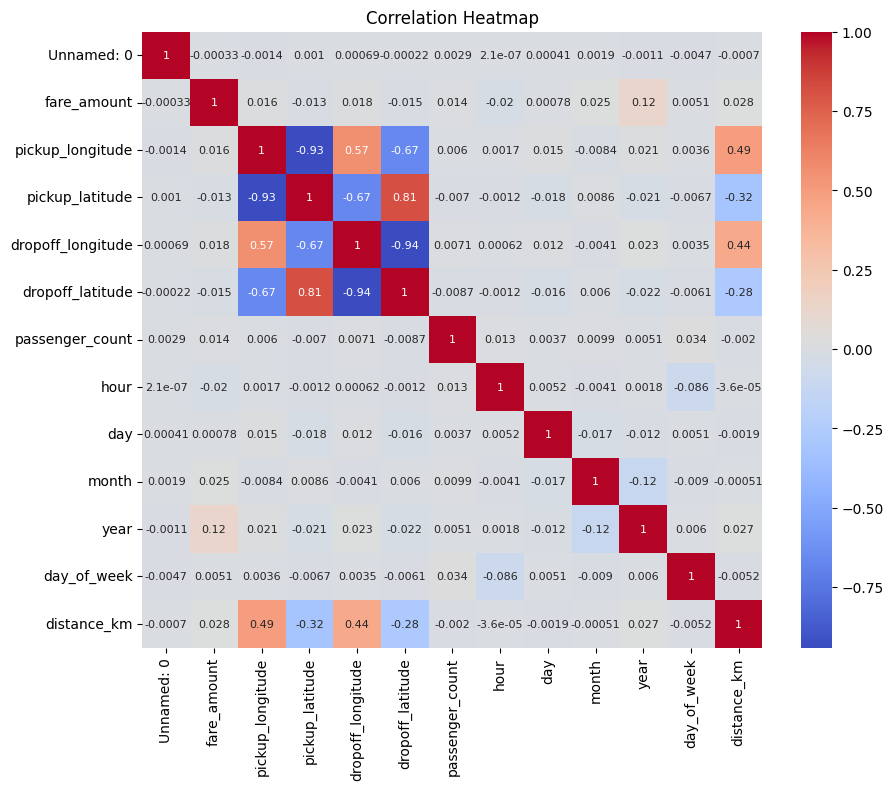

In [10]:
# Corelation Analysis
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', annot_kws={'size': 8})
plt.title('Correlation Heatmap')
plt.show()

# Model Training

In [11]:
# Define features and targets
X = df[['distance_km', 'hour', 'day', 'month', 'year', 'day_of_week']]
y = df['fare_amount']

# split data into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 42)

#---------Linear Regression----------
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

#---------Random Forest Regression--------
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)



# Model Evaluation

In [12]:
def evaluate_model(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"\nModel: {model_name}")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    return r2, rmse, mae

# Evaluate both models
lr_scores = evaluate_model(y_test, lr_pred, "Linear Regression")
rf_scores = evaluate_model(y_test, rf_pred, "Random Forest Regressor")


Model: Linear Regression
R² Score: 0.0172
RMSE: 9.4318
MAE: 5.9225

Model: Random Forest Regressor
R² Score: 0.8191
RMSE: 4.0466
MAE: 2.1520


In [13]:
# Comparison
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest Regressor'],
    'R2': [lr_scores[0], rf_scores[0]],
    'RMSE': [lr_scores[1], rf_scores[1]],
    'MAE': [lr_scores[2], rf_scores[2]]
})

print("\nModel Comparison:")
print(results)


Model Comparison:
                     Model        R2      RMSE       MAE
0        Linear Regression  0.017172  9.431814  5.922463
1  Random Forest Regressor  0.819084  4.046640  2.151991


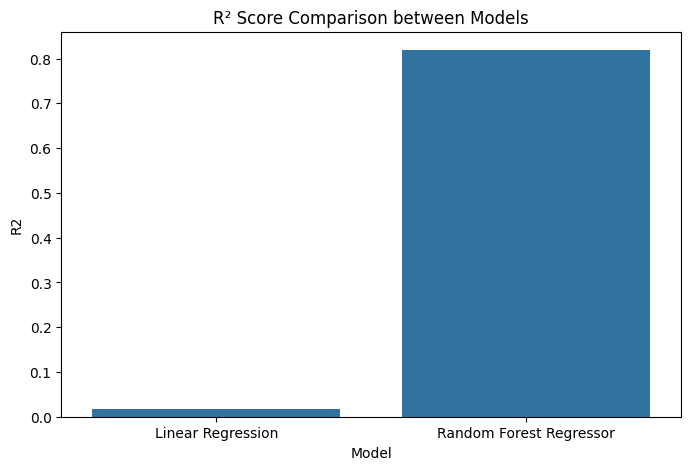

In [14]:
# Plot comparison
plt.figure(figsize=(8,5))
sns.barplot(x='Model', y='R2', data=results)
plt.title("R² Score Comparison between Models")
plt.show()